Однопараметровый случай YRI_CEU, в котором пробую перебирать для каждого параметра обычный вход и логарифм и меряю оптимизиравонное значение и кол-во итераций

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

import moments
# In demographic_models.py, we've defined a custom model for this problem
import demographic_models

import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

from functools import partial

import pandas as pd

In [17]:
# Load the data
data = moments.Spectrum.from_file('YRI_CEU.fs')
ns = data.sample_sizes

In [8]:
popt = np.array([1.881, 0.0710, 1.845, 0.911, 0.355, 0.111])

#Define the objective function
def obj_func(is_log, i, parameter_set):
    # We'll work with YRI_CEU custom model
    func = demographic_models.prior_onegrow_mig
    
    lls = []
    parameters = popt.copy()
    for parameter in parameter_set:
        # Calculate the model AFS.
        
        if is_log: 
            parameter = np.exp(parameter)
        parameters[i] = parameter
        
        model = func(parameters, ns)
        
        # Likelihood of the data given the model AFS.
        ll_model = moments.Inference.ll_multinom(model, data)
        
        lls.append([-ll_model])  # minus for maximization
    return np.array(lls)

In [12]:
# The upper_bound and lower_bound lists are for use in optimization.
# Occasionally the optimizer will try wacky parameter values. We in particular
# want to exclude values with very long times, very small population sizes, or
# very high migration rates, as they will take a long time to evaluate.
# Parameters are: (nu1F, nu2B, nu2F, m, Tp, T)
upper_bound = np.array([100, 100, 100, 10, 3, 3])

# add 1e-5 to last three values to shift from zero value
lower_bound = np.array([1e-2, 1e-2, 1e-2, 1e-5, 1e-5, 1e-5])

In [13]:
domain = np.array([{'name': 'X' + str(bd), 'type': 'continuous', 'domain': bd} 
                   for bd in zip(lower_bound, upper_bound)])

In [14]:
# This is our initial guess for the parameters, which is somewhat arbitrary.
p0 = np.array([[2, 0.1, 2, 1, 0.2, 0.2]])

In [15]:
up_log = np.log(upper_bound)
lo_log = np.log(lower_bound)

dom_log = np.array([{'name': 'X' + str(bd), 'type': 'continuous', 'domain': bd} 
                   for bd in zip(lo_log, up_log)])
p0_log = np.log(p0)

In [19]:
EVALS = 'evaluations/'

In [20]:
def calc(is_log, i, max_time=30, max_iter=100):
    print('Calculation for %d started' % i)
    bo = BayesianOptimization(f=partial(obj_func, is_log, i), 
                              domain=[dom_log[i] if is_log else domain[i]],
                              model_type='GP',
                              kernel=GPy.kern.Matern52(input_dim=1), # one param opt
                              acquisition_type ='EI'
                             )

    eval_filename = EVALS + '%d_%d%s.csv' % (max_time, i, 'log' if is_log else '')
    
    bo.run_optimization(max_time=max_time, max_iter=max_iter, evaluations_file=eval_filename)
#     bo.run_optimization(max_time=max_time, max_iter=max_iter, eps = tolerance, verbosity=True)
    print('\t Calculation for %d done' % i)
    return bo

In [1]:
def draw(is_log, bo):
    bo.plot_acquisition()
    bo.plot_convergence()
    
    x_opt = np.exp(bo.x_opt) if is_log else bo.x_opt
    print 'The minumum value obtained by the function was %.4f (x = %s)' % (-bo.fx_opt, np.array2string(x_opt))

Calculation for 0 started
	 Calculation for 0 done


<IPython.core.display.Javascript object>


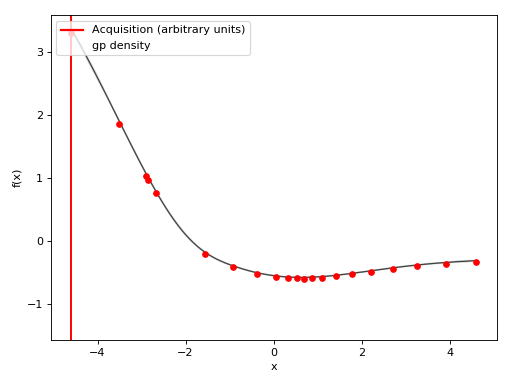

<IPython.core.display.Javascript object>


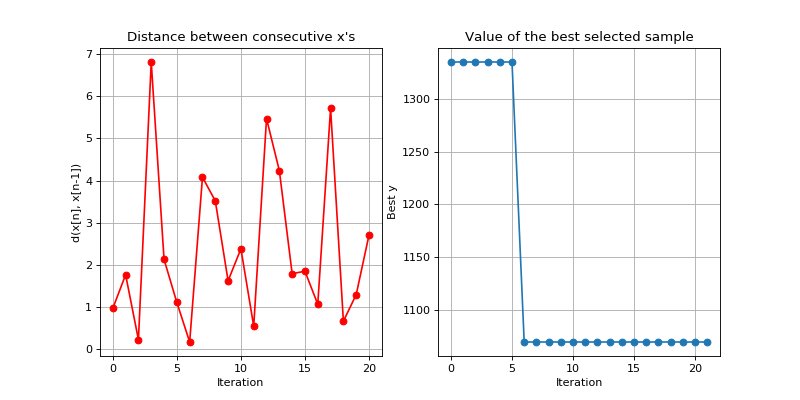

The minumum value obtained by the function was -1069.4853 (x = [1.99416215])


In [23]:
draw(True, calc(True, 0, 10))

In [12]:
# bos = [calc(False, i) for i in range(p0.shape[1])]

### 30 secs evaluations result for one parameter optimization

In [13]:
# bo_logs = [calc(True, i) for i in range(p0.shape[1])]

In [7]:
evals = [pd.DataFrame.from_csv('evaluations/%d.csv' % i, sep='\t') for i in range(p0.shape[1])]

In [8]:
eval_logs = [pd.DataFrame.from_csv('evaluations/%dlog.csv' % i, sep='\t') for i in range(p0.shape[1])]

In [9]:
get_bo_pars = lambda x: (x.model_parameters_iterations.shape[0], -x.fx_opt)
get_eval_pars = lambda x: (x.shape[0], -x['Y'].min())

columns = ['Iters', 'Max value', 'Log iters', 'Log max']
index = 'nu1F, nu2B, nu2F, m, Tp, T'.split(', ')

# df = pd.DataFrame(np.hstack((map(get_bo_pars, bos), map(get_bo_pars, bo_logs))), index=index, columns=columns)
df = pd.DataFrame(np.hstack((map(get_eval_pars, evals), map(get_eval_pars, eval_logs))), index=index, columns=columns)

In [17]:
df.style.highlight_max(color='lightgreen', axis=1, subset=['Max value', 'Log max'])

,Iters,Max value,Log iters,Log max
nu1F,37,-1068.02,38,-1070.05
nu2B,38,-1271.97,31,-1066.64
nu2F,32,-1405.17,30,-1066.68
m,36,-1067.5,33,-1066.65
Tp,36,-1066.81,31,-1066.83
T,34,-1068.45,41,-1066.81


### 60 secs evaluations result for one parameter optimization

In [23]:
bo60s = [calc(False, i, 60) for i in range(p0.shape[1])]
bo60_logs = [calc(True, i, 60) for i in range(p0.shape[1])]

Calculation for 0 started
	 Calculation for 0 done
Calculation for 1 started
	 Calculation for 1 done
Calculation for 2 started
	 Calculation for 2 done
Calculation for 3 started
	 Calculation for 3 done
Calculation for 4 started
	 Calculation for 4 done
Calculation for 5 started
	 Calculation for 5 done
Calculation for 0 started
	 Calculation for 0 done
Calculation for 1 started
	 Calculation for 1 done
Calculation for 2 started
	 Calculation for 2 done
Calculation for 3 started
	 Calculation for 3 done
Calculation for 4 started
	 Calculation for 4 done
Calculation for 5 started
	 Calculation for 5 done


In [24]:
df60 = pd.DataFrame(np.hstack((map(get_bo_pars, bo60s), map(get_bo_pars, bo60_logs))), index=index, columns=columns)

In [25]:
df60.style.highlight_max(color='lightgreen', axis=1, subset=['Max value', 'Log max'])

,Iters,Max value,Log iters,Log max
nu1F,53,-1351.52,45,-1066.99
nu2B,61,-1148.37,34,-1069.17
nu2F,46,-1067.08,35,-1068.42
m,43,-1066.67,35,-1067.69
Tp,42,-1066.85,37,-1066.84
T,30,-1572.75,60,-1067.17


### 120 secs evaluations result for one parameter optimization

In [26]:
bo120s = [calc(False, i, 120) for i in range(p0.shape[1])]
bo120_logs = [calc(True, i, 120) for i in range(p0.shape[1])]

Calculation for 0 started
	 Calculation for 0 done
Calculation for 1 started
	 Calculation for 1 done
Calculation for 2 started
	 Calculation for 2 done
Calculation for 3 started
	 Calculation for 3 done
Calculation for 4 started
	 Calculation for 4 done
Calculation for 5 started
	 Calculation for 5 done
Calculation for 0 started
	 Calculation for 0 done
Calculation for 1 started
	 Calculation for 1 done
Calculation for 2 started
	 Calculation for 2 done
Calculation for 3 started
	 Calculation for 3 done
Calculation for 4 started
	 Calculation for 4 done
Calculation for 5 started
	 Calculation for 5 done


In [28]:
df120 = pd.DataFrame(np.hstack((map(get_bo_pars, bo120s), map(get_bo_pars, bo120_logs))), index=index, columns=columns)

In [29]:
df120.style.highlight_max(color='lightgreen', axis=1, subset=['Max value', 'Log max'])

,Iters,Max value,Log iters,Log max
nu1F,75,-1110.84,84,-1068.66
nu2B,70,-1191.08,63,-1067.03
nu2F,66,-1108.7,77,-1066.85
m,65,-1067.15,73,-1066.64
Tp,57,-1066.83,67,-1066.81
T,68,-1066.57,101,-1067.64


In [2]:
draw(False, bo120s[-1])

NameError: name 'bo120s' is not defined

<IPython.core.display.Javascript object>


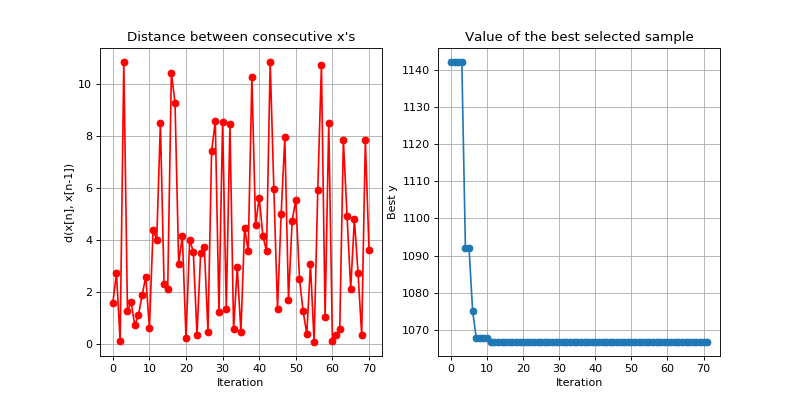

The minumum value obtained by the function was -1066.8135 (x = [0.36050057])


<IPython.core.display.Javascript object>


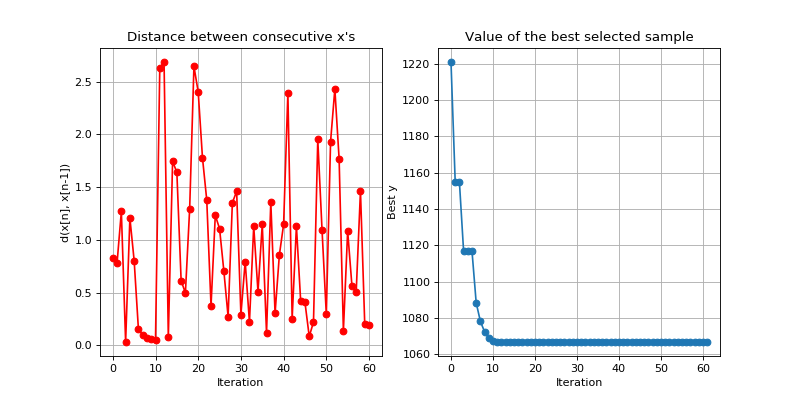

The minumum value obtained by the function was -1066.8261 (x = [0.36933044])


In [38]:
draw(True, bo120_logs[-2])
draw(False, bo120s[-2])

<IPython.core.display.Javascript object>


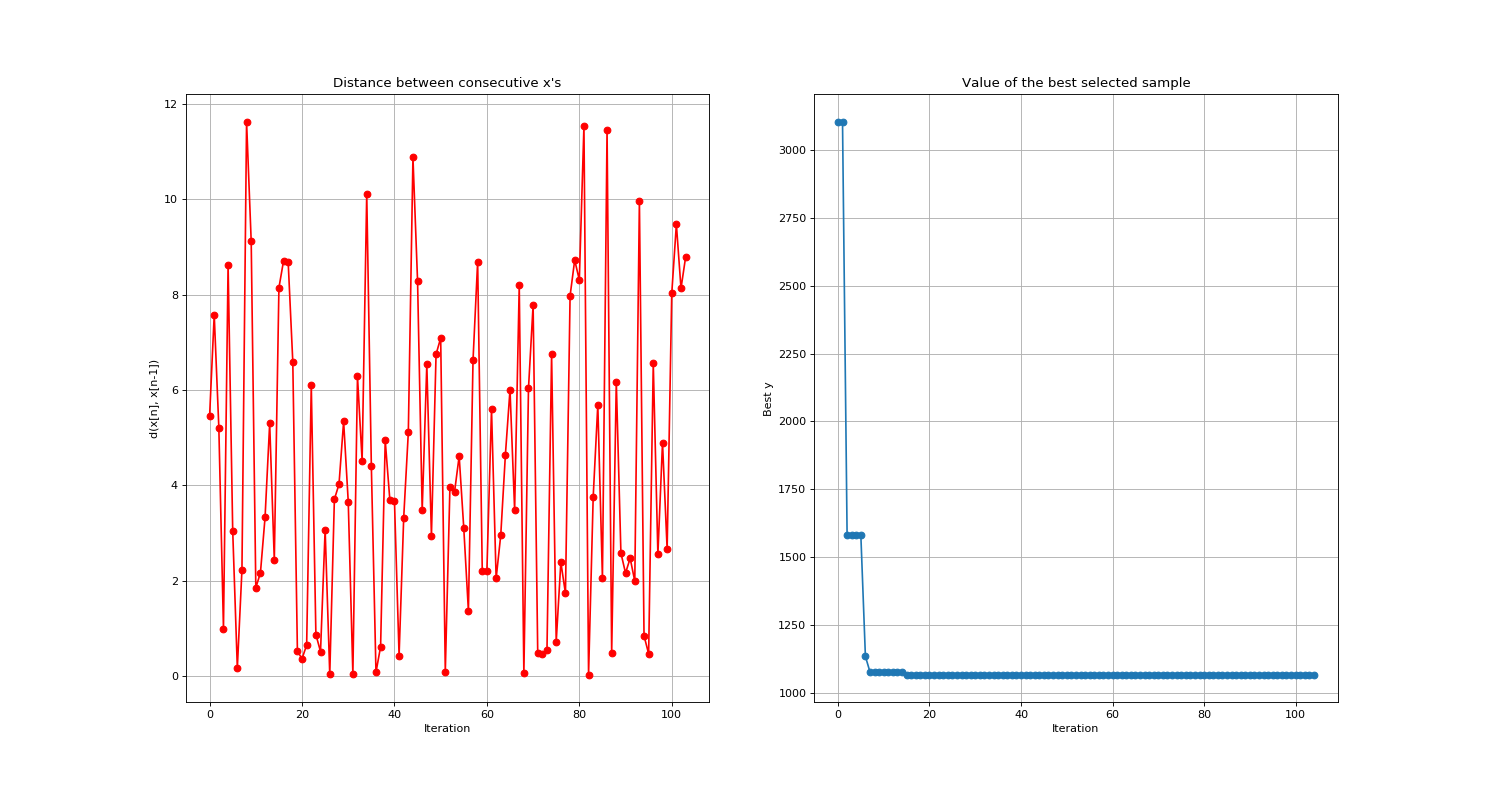

The minumum value obtained by the function was -1067.6387 (x = [-2.246172])


In [34]:
draw(False, bo120_logs[-1])